In [1]:
maxD = 5
inTime = 240
otTime = 480

In [2]:
import sys
sys.path.append("C:\Program Files\Tinysoft\Analyse.NET")
sys.path.append(r"C:\Users\xudong\Documents\github\coresearch\funcs")
import pymongo
import numpy as np
import pickle
import time
import datetime
import copy
import pandas as pd
from operator import itemgetter
import TSLPy3 as tsl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import talib
import importlib
import rschLib
np.set_printoptions(formatter={'float_kind': "{:.6f}".format})
client = pymongo.MongoClient('localhost', 27017)
#db = rschLib.db_quanLiang()
#dbt = rschLib.db_tinySoftData()
dtes, tkrs, name, open_mtx, high_mtx, low_mtx, close_mtx,belong, shenwan1, shenwan2, shenwan3, vol_mtx, amount_mtx = rschLib.loadDailyBarMtx("D:\\pklWeeklyUpdate\\")
# get time labels
# get trades


In [13]:
strategy_names = [x['file'] for x in rschLib.tagDict().values()]
offStarts = [x['off_start'] for x in rschLib.tagDict().values()]
importlib.reload(rschLib)

<module 'rschLib' from 'C:\\Users\\xudong\\Documents\\github\\coresearch\\funcs\\rschLib.py'>

In [73]:
def analyzeStrategy(strategy_name, offStart, dtes, name, tkrs):
    timeAsFloat, timeLabels, maxM, dayOff, dayTimeAsFloat = rschLib.getTimeLabels(maxD)
    R = open_mtx[:, 1:]/close_mtx[:,:-1]-1  #使用收盘到开盘的回报率来修正分红和拆股
    R = np.hstack((np.zeros((R.shape[0],1)), R))
    tradesUsed, r_withnan = rschLib.getTradesFast(strategy_name, name, tkrs, dtes, maxD, dayTimeAsFloat, R)
    # get trade samples by good/bad trades
    tradeArea=[inTime,otTime]
    idxTradable = np.isfinite(r_withnan[:,tradeArea[0]])
    r = r_withnan.copy()
    r[np.isfinite(r)==False]=0
    result = rschLib.getTradeAnalysisSampleGroups(r, idxTradable, tradeArea)

    # draw price change
    rschLib.drawPriceChange(r[idxTradable,:], strategy_name, timeLabels=timeLabels, tp=tradeArea)
    rschLib.drawPriceChange(result['rGood10'], strategy_name, timeLabels=timeLabels, title='盈利前10%交易', tp=tradeArea)
    #rschLib.drawPriceChange(result['rGood20'], strategy_name, timeLabels=timeLabels, title='盈利前20%交易', tp=tradeArea)
    rschLib.drawPriceChange(result['rGood30'], strategy_name, timeLabels=timeLabels, title='盈利前30%交易', tp=tradeArea)
    rschLib.drawPriceChange(result['rBad10'], strategy_name, timeLabels=timeLabels, title='亏损前10%交易',  tp=tradeArea)
    #rschLib.drawPriceChange(result['rBad20'], strategy_name, timeLabels=timeLabels, title='亏损前20%交易',  tp=tradeArea)
    rschLib.drawPriceChange(result['rBad30'], strategy_name, timeLabels=timeLabels, title='亏损前30%交易',  tp=tradeArea)
    
    # analyze tags
    #rschLib.analyzeTradeTags(tradesUsed, result['rGood10'], result['idxGood10'], '盈利前10%交易',strategy_name, dtes, tkrs, offStart)
    #rschLib.analyzeTradeTags(tradesUsed, result['rGood20'], result['idxGood20'], '盈利前20%交易',strategy_name, dtes, tkrs, offStart)
    #rschLib.analyzeTradeTags(tradesUsed, result['rGood30'], result['idxGood30'], '盈利前30%交易',strategy_name, dtes, tkrs, offStart)
    #rschLib.analyzeTradeTags(tradesUsed, result['rBad10'], result['idxBad10'], '亏损前10%交易',strategy_name, dtes, tkrs, offStart)
    #rschLib.analyzeTradeTags(tradesUsed, result['rBad20'], result['idxBad20'], '亏损前20%交易',strategy_name, dtes, tkrs, offStart)
    #rschLib.analyzeTradeTags(tradesUsed, result['rBad30'], result['idxBad30'], '亏损前30%交易',strategy_name, dtes, tkrs, offStart)

    #get tag names
    tnames, tagNamesEn,t2 = rschLib.getTagNames()
    idxOverLapTagList=rschLib.analyzeTradeTags(tradesUsed, r, list(range(len(tradesUsed))), '所有交易',strategy_name, dtes, tkrs, offStart, "d:\\pklWeeklyUpdate\\")

    #draw pnl and tag pnl
    importlib.reload(rschLib)
    [dtesByTrade, pnlByTrade] = rschLib.getPnlFast(r, dtes, tkrs, name, tradesUsed, inTime, otTime, dayOff, timeAsFloat, toDatabase='yes', strategy_name=strategy_name)
    [dtesPnlAggr,pnlAggr, numTrades] = rschLib.aggregatePnlAndDtes(dtesByTrade, pnlByTrade)
    rschLib.drawPNL(dtesPnlAggr, pnlAggr, dtes, strategy_name,showFigure='no', toDatabase='yes')
    for i in range(len(tnames)):
        tagName = tnames[i]
        [dtesWithTag, pnlWithTag,n] = rschLib.aggregatePnlAndDtes(dtesByTrade[idxOverLapTagList[i]],pnlByTrade[idxOverLapTagList[i]])
        rschLib.drawPNL(dtesWithTag, pnlWithTag, dtes, strategy_name, showFigure='no', toDatabase='yes', dateStart=dtesPnlAggr[0], pnlType=tagName)
        rschLib.drawPNL(dtesWithTag, pnlWithTag, dtes, strategy_name+'+'+tagNamesEn[i], showFigure='no',  toDatabase='yes', dateStart=dtesPnlAggr[0], pnlType='pnl')

    #analysis of number of trades vs performance
    importlib.reload(rschLib)
    rschLib.pnlVsNumtrades(pnlAggr, numTrades, strategy_name, toDatabase='yes')
    rschLib.saveOffStart(strategy_name, offStart)

In [ ]:
import threadpool
importlib.reload(rschLib)
arg_list=[]#存放任务列表  
#首先构造任务列表  
for (i,strategy_name) in enumerate(strategy_names):
    if i<8:
        continue
    offStart = offStarts[i]
    analyzeStrategy(strategy_name, offStart, dtes, name, tkrs)


C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


tagValumeDouble 最后完整日期 0 新增记录 167075 总记录 167075


C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:601: RuntimeWarning: invalid value encountered in true_divide
  ro2c = closeList/openList - 1
C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:604: RuntimeWarning: invalid value encountered in true_divide
  rc2o[1:] = openList[1:]/closeList[:-1] - 1


tagValumeDouble bulk write SZ300675 20180104 20180110
tagValumeDouble bulk write SH601166 20180111 20180117
tagValumeDouble bulk write SZ002726 20180116 20180122
tagValumeDouble bulk write SH600189 20180123 20180129
tagValumeDouble bulk write SZ000875 20180201 20180207
tagValumeDouble bulk write SH600446 20180207 20180213
tagValumeDouble bulk write SH601005 20180212 20180223
tagValumeDouble bulk write SH600895 20180226 20180302
tagValumeDouble bulk write SZ002035 20180228 20180306
10000 / 167075 20180228
tagValumeDouble bulk write SH603345 20180307 20180313
tagValumeDouble bulk write SZ000099 20180312 20180316
tagValumeDouble bulk write SH601163 20180316 20180322
tagValumeDouble bulk write SH603336 20180322 20180328
tagValumeDouble bulk write SZ000869 20180326 20180330
tagValumeDouble bulk write SH600372 20180402 20180410
tagValumeDouble bulk write SZ300545 20180410 20180416
tagValumeDouble bulk write SZ000848 20180417 20180423
tagValumeDouble bulk write SH603656 20180425 20180503
tagV

C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:604: RuntimeWarning: divide by zero encountered in true_divide
  rc2o[1:] = openList[1:]/closeList[:-1] - 1


tagValumeDouble bulk write SZ002573 20190807 20190813
tagValumeDouble bulk write SZ002163 20190815 20190821
tagValumeDouble bulk write SZ002211 20190820 20190826
tagValumeDouble bulk write SZ002432 20190826 20190830
tagValumeDouble bulk write SZ002395 20190830 20190905
tagValumeDouble bulk write SZ002631 20190905 20190911
tagValumeDouble bulk write SZ002028 20190919 20190925
100000 / 167075 20190919
tagValumeDouble bulk write SZ300041 20190925 20191008
tagValumeDouble bulk write SH600583 20191011 20191017
tagValumeDouble bulk write SZ300221 20191016 20191022
tagValumeDouble bulk write SH600097 20191024 20191030
tagValumeDouble bulk write SH600336 20191104 20191108
tagValumeDouble bulk write SH603583 20191111 20191115
tagValumeDouble bulk write SH603856 20191118 20191122
tagValumeDouble bulk write SZ300783 20191122 20191128
tagValumeDouble bulk write SZ002618 20191128 20191204
110000 / 167075 20191128
tagValumeDouble bulk write SZ300727 20191204 20191210
tagValumeDouble bulk write SH600

C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


tagCirculateMarketValueBiggerThan100Y 最后完整日期 0 新增记录 524015 总记录 524015
tagCirculateMarketValueBiggerThan100Y bulk write SH600000 20180102 20180108
0 / 524015 20180102


C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:601: RuntimeWarning: invalid value encountered in true_divide
  ro2c = closeList/openList - 1
C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:604: RuntimeWarning: invalid value encountered in true_divide
  rc2o[1:] = openList[1:]/closeList[:-1] - 1


tagCirculateMarketValueBiggerThan100Y bulk write SH600763 20180103 20180109
tagCirculateMarketValueBiggerThan100Y bulk write SZ000703 20180104 20180110
tagCirculateMarketValueBiggerThan100Y bulk write SZ300024 20180105 20180111
tagCirculateMarketValueBiggerThan100Y bulk write SH600637 20180109 20180115
tagCirculateMarketValueBiggerThan100Y bulk write SZ000423 20180110 20180116
tagCirculateMarketValueBiggerThan100Y bulk write SZ002555 20180111 20180117
tagCirculateMarketValueBiggerThan100Y bulk write SH600500 20180115 20180119
tagCirculateMarketValueBiggerThan100Y bulk write SZ002408 20180117 20180123
tagCirculateMarketValueBiggerThan100Y bulk write SH600346 20180119 20180125
10000 / 524015 20180119
tagCirculateMarketValueBiggerThan100Y bulk write SH601808 20180122 20180126
tagCirculateMarketValueBiggerThan100Y bulk write SZ002221 20180123 20180129
tagCirculateMarketValueBiggerThan100Y bulk write SH600188 20180125 20180131
tagCirculateMarketValueBiggerThan100Y bulk write SH601229 201801

tagCirculateMarketValueBiggerThan100Y bulk write SZ002127 20180827 20180831
tagCirculateMarketValueBiggerThan100Y bulk write SH600795 20180829 20180904
tagCirculateMarketValueBiggerThan100Y bulk write SZ002430 20180830 20180905
tagCirculateMarketValueBiggerThan100Y bulk write SH601139 20180903 20180907
tagCirculateMarketValueBiggerThan100Y bulk write SH600022 20180905 20180911
tagCirculateMarketValueBiggerThan100Y bulk write SZ000750 20180906 20180912
tagCirculateMarketValueBiggerThan100Y bulk write SH600803 20180910 20180914
120000 / 524015 20180910
tagCirculateMarketValueBiggerThan100Y bulk write SZ300207 20180911 20180917
tagCirculateMarketValueBiggerThan100Y bulk write SH600660 20180917 20180921
tagCirculateMarketValueBiggerThan100Y bulk write SZ002640 20180918 20180925
tagCirculateMarketValueBiggerThan100Y bulk write SZ000040 20180920 20180927
tagCirculateMarketValueBiggerThan100Y bulk write SH600535 20180925 20181008
tagCirculateMarketValueBiggerThan100Y bulk write SZ002430 20180

tagCirculateMarketValueBiggerThan100Y bulk write SH600000 20190516 20190522
220000 / 524015 20190516
tagCirculateMarketValueBiggerThan100Y bulk write SH600926 20190517 20190523
tagCirculateMarketValueBiggerThan100Y bulk write SZ002002 20190520 20190524
tagCirculateMarketValueBiggerThan100Y bulk write SH600166 20190522 20190528
tagCirculateMarketValueBiggerThan100Y bulk write SH601618 20190523 20190529
tagCirculateMarketValueBiggerThan100Y bulk write SZ002273 20190524 20190530
tagCirculateMarketValueBiggerThan100Y bulk write SH600409 20190528 20190603
tagCirculateMarketValueBiggerThan100Y bulk write SH603699 20190529 20190604
tagCirculateMarketValueBiggerThan100Y bulk write SZ002602 20190530 20190605
tagCirculateMarketValueBiggerThan100Y bulk write SH600649 20190603 20190610
tagCirculateMarketValueBiggerThan100Y bulk write SZ000739 20190604 20190611
230000 / 524015 20190604
tagCirculateMarketValueBiggerThan100Y bulk write SH600269 20190606 20190613
tagCirculateMarketValueBiggerThan100Y 

C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:604: RuntimeWarning: divide by zero encountered in true_divide
  rc2o[1:] = openList[1:]/closeList[:-1] - 1


tagCirculateMarketValueBiggerThan100Y bulk write SZ000761 20190801 20190807
tagCirculateMarketValueBiggerThan100Y bulk write SH600171 20190805 20190809
260000 / 524015 20190805
tagCirculateMarketValueBiggerThan100Y bulk write SH603156 20190806 20190812
tagCirculateMarketValueBiggerThan100Y bulk write SZ300168 20190807 20190813
tagCirculateMarketValueBiggerThan100Y bulk write SH601106 20190809 20190815
tagCirculateMarketValueBiggerThan100Y bulk write SZ002311 20190812 20190816
tagCirculateMarketValueBiggerThan100Y bulk write SH600663 20190814 20190820
tagCirculateMarketValueBiggerThan100Y bulk write SZ000902 20190815 20190821
tagCirculateMarketValueBiggerThan100Y bulk write SH600307 20190819 20190823
tagCirculateMarketValueBiggerThan100Y bulk write SZ000001 20190820 20190826
tagCirculateMarketValueBiggerThan100Y bulk write SZ300760 20190821 20190827
tagCirculateMarketValueBiggerThan100Y bulk write SH601369 20190823 20190829
270000 / 524015 20190823
tagCirculateMarketValueBiggerThan100Y 

tagCirculateMarketValueBiggerThan100Y bulk write SH600271 20200309 20200313
tagCirculateMarketValueBiggerThan100Y bulk write SH601018 20200310 20200316
tagCirculateMarketValueBiggerThan100Y bulk write SZ000547 20200311 20200317
tagCirculateMarketValueBiggerThan100Y bulk write SZ002414 20200312 20200318
tagCirculateMarketValueBiggerThan100Y bulk write SH600050 20200316 20200320
tagCirculateMarketValueBiggerThan100Y bulk write SH600782 20200317 20200323
tagCirculateMarketValueBiggerThan100Y bulk write SH603737 20200318 20200324
370000 / 524015 20200318
tagCirculateMarketValueBiggerThan100Y bulk write SZ002142 20200319 20200325
tagCirculateMarketValueBiggerThan100Y bulk write SZ300376 20200320 20200326
tagCirculateMarketValueBiggerThan100Y bulk write SH600549 20200324 20200330
tagCirculateMarketValueBiggerThan100Y bulk write SH601808 20200325 20200331
tagCirculateMarketValueBiggerThan100Y bulk write SZ000951 20200326 20200401
tagCirculateMarketValueBiggerThan100Y bulk write SZ002939 20200

tagCirculateMarketValueBiggerThan100Y bulk write SH601098 20200904 20200910
470000 / 524015 20200904
tagCirculateMarketValueBiggerThan100Y bulk write SH600887 20200907 20200911
tagCirculateMarketValueBiggerThan100Y bulk write SH600787 20200908 20200914
tagCirculateMarketValueBiggerThan100Y bulk write SH600673 20200909 20200915
tagCirculateMarketValueBiggerThan100Y bulk write SH600570 20200910 20200916
tagCirculateMarketValueBiggerThan100Y bulk write SH600456 20200911 20200917
tagCirculateMarketValueBiggerThan100Y bulk write SH600332 20200914 20200918
tagCirculateMarketValueBiggerThan100Y bulk write SH600208 20200915 20200921
tagCirculateMarketValueBiggerThan100Y bulk write SH600094 20200916 20200922
tagCirculateMarketValueBiggerThan100Y bulk write SH600016 20200917 20200923
tagCirculateMarketValueBiggerThan100Y bulk write SZ300628 20200917 20200923
480000 / 524015 20200917
tagCirculateMarketValueBiggerThan100Y bulk write SZ300376 20200918 20200924
tagCirculateMarketValueBiggerThan100Y 

tagCirculateMarketValueBiggerThan100Y getPnl() at  420000 / 514925
tagCirculateMarketValueBiggerThan100Y getPnl() at  430000 / 514925
tagCirculateMarketValueBiggerThan100Y getPnl() at  440000 / 514925
tagCirculateMarketValueBiggerThan100Y getPnl() at  450000 / 514925
tagCirculateMarketValueBiggerThan100Y getPnl() at  460000 / 514925
tagCirculateMarketValueBiggerThan100Y getPnl() at  470000 / 514925
tagCirculateMarketValueBiggerThan100Y getPnl() at  480000 / 514925
tagCirculateMarketValueBiggerThan100Y getPnl() at  490000 / 514925
tagCirculateMarketValueBiggerThan100Y getPnl() at  500000 / 514925
tagCirculateMarketValueBiggerThan100Y getPnl() at  510000 / 514925


C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:399: RuntimeWarning: invalid value encountered in double_scalars
  

tagCirculateMarketValueBiggerThan250Y 最后完整日期 0 新增记录 204160 总记录 204160
tagCirculateMarketValueBiggerThan250Y bulk write SH600000 20180102 20180108
0 / 204160 20180102


C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:601: RuntimeWarning: invalid value encountered in true_divide
  ro2c = closeList/openList - 1
C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:604: RuntimeWarning: invalid value encountered in true_divide
  rc2o[1:] = openList[1:]/closeList[:-1] - 1


tagCirculateMarketValueBiggerThan250Y bulk write SZ000963 20180105 20180111
tagCirculateMarketValueBiggerThan250Y bulk write SH601985 20180111 20180117
tagCirculateMarketValueBiggerThan250Y bulk write SH601012 20180117 20180123
tagCirculateMarketValueBiggerThan250Y bulk write SH600383 20180123 20180129
tagCirculateMarketValueBiggerThan250Y bulk write SH600009 20180129 20180202
tagCirculateMarketValueBiggerThan250Y bulk write SZ000999 20180201 20180207
tagCirculateMarketValueBiggerThan250Y bulk write SH601985 20180207 20180213
tagCirculateMarketValueBiggerThan250Y bulk write SH601006 20180213 20180226
tagCirculateMarketValueBiggerThan250Y bulk write SH600369 20180226 20180302
tagCirculateMarketValueBiggerThan250Y bulk write SZ300015 20180301 20180307
10000 / 204160 20180301
tagCirculateMarketValueBiggerThan250Y bulk write SZ000671 20180307 20180313
tagCirculateMarketValueBiggerThan250Y bulk write SH601336 20180313 20180319
tagCirculateMarketValueBiggerThan250Y bulk write SH600519 201803

C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:604: RuntimeWarning: divide by zero encountered in true_divide
  rc2o[1:] = openList[1:]/closeList[:-1] - 1


tagCirculateMarketValueBiggerThan250Y bulk write SH600406 20190813 20190819
tagCirculateMarketValueBiggerThan250Y bulk write SZ002475 20190816 20190822
tagCirculateMarketValueBiggerThan250Y bulk write SH601991 20190822 20190828
100000 / 204160 20190822
tagCirculateMarketValueBiggerThan250Y bulk write SH600663 20190828 20190903
tagCirculateMarketValueBiggerThan250Y bulk write SZ300383 20190902 20190906
tagCirculateMarketValueBiggerThan250Y bulk write SZ000860 20190906 20190912
tagCirculateMarketValueBiggerThan250Y bulk write SH601766 20190912 20190919
tagCirculateMarketValueBiggerThan250Y bulk write SH600690 20190919 20190925
tagCirculateMarketValueBiggerThan250Y bulk write SH600050 20190925 20191008
tagCirculateMarketValueBiggerThan250Y bulk write SZ002230 20190930 20191011
tagCirculateMarketValueBiggerThan250Y bulk write SH601899 20191011 20191017
tagCirculateMarketValueBiggerThan250Y bulk write SH600436 20191017 20191023
tagCirculateMarketValueBiggerThan250Y bulk write SZ002371 20191

tagCirculateMarketValueBiggerThan250Y bulk write SH600406 20201125 20201201
tagCirculateMarketValueBiggerThan250Y bulk write SZ000423 20201127 20201201
['净利润增速连续三年大于20%', '季度净利润连续三年大于1亿', '跳空高开', '突破1年新高(开盘)', '突破3个月新高(开盘)', '均线多头排列', 'MACD的DIFF高于DEA', 'MACD的DIFF大于0', '交易量放大2倍', '流通市值大于100亿', '流通市值大于250亿', '流通市值大于500亿', '流通市值小于100亿', '流通市值小于50亿', '流通市值小于25亿', 'KDJ金叉', '十大股东持股比例小于20%', '十大股东持股比例20%~50%', '十大股东持股比例50%~80%', '十大股东持股比例大于80%', '交通运输', '休闲服务', '传媒', '公用事业', '农林牧渔', '化工', '医药生物', '商业贸易', '国防军工', '家用电器', '建筑材料', '建筑装饰', '房地产', '有色金属', '机械设备', '汽车', '电子', '电气设备', '纺织服装', '综合', '计算机', '轻工制造', '通信', '采掘', '钢铁', '银行', '非银金融', '食品饮料']
所有交易 净利润增速连续三年大于20% 7.03
所有交易 季度净利润连续三年大于1亿 65.43
所有交易 跳空高开 2.26
所有交易 突破1年新高(开盘) 0.59
所有交易 突破3个月新高(开盘) 1.05
所有交易 均线多头排列 28.0
所有交易 MACD的DIFF高于DEA 3.82
所有交易 MACD的DIFF大于0 51.8
所有交易 交易量放大2倍 5.28
所有交易 流通市值大于100亿 100.0
所有交易 流通市值大于250亿 99.77
所有交易 流通市值大于500亿 43.08
所有交易 流通市值小于100亿 0.0
所有交易 流通市值小于50亿 0.0
所有交易 流通市值小于25亿 0.0
所有交易 KDJ金叉 8.48
所有交易 十大股东持股比例小于20% 0.9

C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:399: RuntimeWarning: invalid value encountered in double_scalars
  

tagCirculateMarketValueBiggerThan500Y 最后完整日期 0 新增记录 87867 总记录 87867
tagCirculateMarketValueBiggerThan500Y bulk write SH600000 20180102 20180108
0 / 87867 20180102


C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:601: RuntimeWarning: invalid value encountered in true_divide
  ro2c = closeList/openList - 1
C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:604: RuntimeWarning: invalid value encountered in true_divide
  rc2o[1:] = openList[1:]/closeList[:-1] - 1


tagCirculateMarketValueBiggerThan500Y bulk write SH600030 20180115 20180119
tagCirculateMarketValueBiggerThan500Y bulk write SH600048 20180208 20180214
tagCirculateMarketValueBiggerThan500Y bulk write SZ002230 20180227 20180305
tagCirculateMarketValueBiggerThan500Y bulk write SH601633 20180312 20180316
tagCirculateMarketValueBiggerThan500Y bulk write SZ000895 20180404 20180412
tagCirculateMarketValueBiggerThan500Y bulk write SH601800 20180419 20180425
tagCirculateMarketValueBiggerThan500Y bulk write SH601111 20180504 20180510
tagCirculateMarketValueBiggerThan500Y bulk write SH600900 20180517 20180523
10000 / 87867 20180517
tagCirculateMarketValueBiggerThan500Y bulk write SH600588 20180530 20180605
tagCirculateMarketValueBiggerThan500Y bulk write SH600048 20180612 20180619
tagCirculateMarketValueBiggerThan500Y bulk write SZ300015 20180625 20180629
tagCirculateMarketValueBiggerThan500Y bulk write SZ300003 20180706 20180712
tagCirculateMarketValueBiggerThan500Y bulk write SH600104 2018072

C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:604: RuntimeWarning: divide by zero encountered in true_divide
  rc2o[1:] = openList[1:]/closeList[:-1] - 1


tagCirculateMarketValueBiggerThan500Y bulk write SH600570 20190816 20190822
tagCirculateMarketValueBiggerThan500Y bulk write SZ001979 20190828 20190903
tagCirculateMarketValueBiggerThan500Y bulk write SH601186 20190910 20190917
tagCirculateMarketValueBiggerThan500Y bulk write SZ300059 20190923 20190927
tagCirculateMarketValueBiggerThan500Y bulk write SH601727 20191011 20191017
tagCirculateMarketValueBiggerThan500Y bulk write SH600958 20191024 20191030
tagCirculateMarketValueBiggerThan500Y bulk write SZ300760 20191105 20191111
tagCirculateMarketValueBiggerThan500Y bulk write SH600383 20191118 20191122
50000 / 87867 20191118
tagCirculateMarketValueBiggerThan500Y bulk write SH601111 20191128 20191204
tagCirculateMarketValueBiggerThan500Y bulk write SH601933 20191210 20191216
tagCirculateMarketValueBiggerThan500Y bulk write SZ002304 20191220 20191226
tagCirculateMarketValueBiggerThan500Y bulk write SH600276 20200103 20200109
tagCirculateMarketValueBiggerThan500Y bulk write SH601808 2020011

C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcPa

['净利润增速连续三年大于20%', '季度净利润连续三年大于1亿', '跳空高开', '突破1年新高(开盘)', '突破3个月新高(开盘)', '均线多头排列', 'MACD的DIFF高于DEA', 'MACD的DIFF大于0', '交易量放大2倍', '流通市值大于100亿', '流通市值大于250亿', '流通市值大于500亿', '流通市值小于100亿', '流通市值小于50亿', '流通市值小于25亿', 'KDJ金叉', '十大股东持股比例小于20%', '十大股东持股比例20%~50%', '十大股东持股比例50%~80%', '十大股东持股比例大于80%', '交通运输', '休闲服务', '传媒', '公用事业', '农林牧渔', '化工', '医药生物', '商业贸易', '国防军工', '家用电器', '建筑材料', '建筑装饰', '房地产', '有色金属', '机械设备', '汽车', '电子', '电气设备', '纺织服装', '综合', '计算机', '轻工制造', '通信', '采掘', '钢铁', '银行', '非银金融', '食品饮料']
所有交易 净利润增速连续三年大于20% 6.16
所有交易 季度净利润连续三年大于1亿 79.92
所有交易 跳空高开 2.23
所有交易 突破1年新高(开盘) 0.63
所有交易 突破3个月新高(开盘) 1.07
所有交易 均线多头排列 28.44
所有交易 MACD的DIFF高于DEA 3.78
所有交易 MACD的DIFF大于0 52.48
所有交易 交易量放大2倍 5.2
所有交易 流通市值大于100亿 100.0
所有交易 流通市值大于250亿 100.0
所有交易 流通市值大于500亿 99.79
所有交易 流通市值小于100亿 0.0
所有交易 流通市值小于50亿 0.0
所有交易 流通市值小于25亿 0.0
所有交易 KDJ金叉 8.5
所有交易 十大股东持股比例小于20% 0.88
所有交易 十大股东持股比例20%~50% 13.92
所有交易 十大股东持股比例50%~80% 46.93
所有交易 十大股东持股比例大于80% 38.27
所有交易 交通运输 5.38
所有交易 休闲服务 0.81
所有交易 传媒 1.25
所有交易 公用事业 3.84
所有交易 农林牧渔 2.1

C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:399: RuntimeWarning: invalid value encountered in double_scalars
  

tagCirculateMarketValueSmallerThan100Y 最后完整日期 0 新增记录 2424476 总记录 2424476


C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:601: RuntimeWarning: invalid value encountered in true_divide
  ro2c = closeList/openList - 1
C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:604: RuntimeWarning: invalid value encountered in true_divide
  rc2o[1:] = openList[1:]/closeList[:-1] - 1


tagCirculateMarketValueSmallerThan100Y bulk write SH603637 20180102 20180108
tagCirculateMarketValueSmallerThan100Y bulk write SZ002239 20180102 20180108
tagCirculateMarketValueSmallerThan100Y bulk write SZ300538 20180102 20180108
tagCirculateMarketValueSmallerThan100Y bulk write SH603136 20180103 20180109
tagCirculateMarketValueSmallerThan100Y bulk write SZ002031 20180103 20180109
tagCirculateMarketValueSmallerThan100Y bulk write SZ300370 20180103 20180109
tagCirculateMarketValueSmallerThan100Y bulk write SH600980 20180104 20180110
tagCirculateMarketValueSmallerThan100Y bulk write SZ000715 20180104 20180110
tagCirculateMarketValueSmallerThan100Y bulk write SZ300196 20180104 20180110
tagCirculateMarketValueSmallerThan100Y bulk write SH600671 20180105 20180111
10000 / 2424476 20180105
tagCirculateMarketValueSmallerThan100Y bulk write SZ300004 20180105 20180111
tagCirculateMarketValueSmallerThan100Y bulk write SH600358 20180108 20180112
tagCirculateMarketValueSmallerThan100Y bulk write S

tagCirculateMarketValueSmallerThan100Y bulk write SZ002552 20180308 20180314
tagCirculateMarketValueSmallerThan100Y bulk write SZ002225 20180309 20180315
140000 / 2424476 20180309
tagCirculateMarketValueSmallerThan100Y bulk write SZ300507 20180309 20180315
tagCirculateMarketValueSmallerThan100Y bulk write SH603005 20180312 20180316
tagCirculateMarketValueSmallerThan100Y bulk write SZ000823 20180312 20180316
tagCirculateMarketValueSmallerThan100Y bulk write SZ300232 20180312 20180316
tagCirculateMarketValueSmallerThan100Y bulk write SH600667 20180313 20180319
tagCirculateMarketValueSmallerThan100Y bulk write SZ002853 20180313 20180319
tagCirculateMarketValueSmallerThan100Y bulk write SH600215 20180314 20180320
tagCirculateMarketValueSmallerThan100Y bulk write SZ002560 20180314 20180320
150000 / 2424476 20180314
tagCirculateMarketValueSmallerThan100Y bulk write SH603677 20180315 20180321
tagCirculateMarketValueSmallerThan100Y bulk write SZ002228 20180315 20180321
tagCirculateMarketValueS

tagCirculateMarketValueSmallerThan100Y bulk write SH603031 20180514 20180518
tagCirculateMarketValueSmallerThan100Y bulk write SZ000852 20180514 20180518
tagCirculateMarketValueSmallerThan100Y bulk write SZ300221 20180514 20180518
tagCirculateMarketValueSmallerThan100Y bulk write SH600626 20180515 20180521
tagCirculateMarketValueSmallerThan100Y bulk write SZ002800 20180515 20180521
tagCirculateMarketValueSmallerThan100Y bulk write SH600101 20180516 20180522
tagCirculateMarketValueSmallerThan100Y bulk write SZ002443 20180516 20180522
tagCirculateMarketValueSmallerThan100Y bulk write SZ300668 20180516 20180522
tagCirculateMarketValueSmallerThan100Y bulk write SH603311 20180517 20180523
tagCirculateMarketValueSmallerThan100Y bulk write SZ002053 20180517 20180523
tagCirculateMarketValueSmallerThan100Y bulk write SZ300345 20180517 20180523
tagCirculateMarketValueSmallerThan100Y bulk write SH600805 20180518 20180524
tagCirculateMarketValueSmallerThan100Y bulk write SZ000430 20180518 20180524

tagCirculateMarketValueSmallerThan100Y bulk write SH600121 20180709 20180713
tagCirculateMarketValueSmallerThan100Y bulk write SZ002385 20180709 20180713
tagCirculateMarketValueSmallerThan100Y bulk write SZ300593 20180709 20180713
tagCirculateMarketValueSmallerThan100Y bulk write SH603038 20180710 20180716
tagCirculateMarketValueSmallerThan100Y bulk write SZ000823 20180710 20180716
410000 / 2424476 20180710
tagCirculateMarketValueSmallerThan100Y bulk write SZ300173 20180710 20180716
tagCirculateMarketValueSmallerThan100Y bulk write SH600512 20180711 20180717
tagCirculateMarketValueSmallerThan100Y bulk write SZ002655 20180711 20180717
tagCirculateMarketValueSmallerThan100Y bulk write SH603656 20180712 20180718
tagCirculateMarketValueSmallerThan100Y bulk write SZ002168 20180712 20180718
tagCirculateMarketValueSmallerThan100Y bulk write SZ300419 20180712 20180718
tagCirculateMarketValueSmallerThan100Y bulk write SH600860 20180713 20180719
tagCirculateMarketValueSmallerThan100Y bulk write 

tagCirculateMarketValueSmallerThan100Y bulk write SZ002058 20180830 20180905
tagCirculateMarketValueSmallerThan100Y bulk write SZ300307 20180830 20180905
tagCirculateMarketValueSmallerThan100Y bulk write SH600716 20180831 20180906
tagCirculateMarketValueSmallerThan100Y bulk write SZ002775 20180831 20180906
540000 / 2424476 20180831
tagCirculateMarketValueSmallerThan100Y bulk write SH603879 20180903 20180907
tagCirculateMarketValueSmallerThan100Y bulk write SZ002280 20180903 20180907
tagCirculateMarketValueSmallerThan100Y bulk write SZ300499 20180903 20180907
tagCirculateMarketValueSmallerThan100Y bulk write SH601015 20180904 20180910
tagCirculateMarketValueSmallerThan100Y bulk write SZ000590 20180904 20180910
tagCirculateMarketValueSmallerThan100Y bulk write SZ002927 20180904 20180910
tagCirculateMarketValueSmallerThan100Y bulk write SH600222 20180905 20180911
tagCirculateMarketValueSmallerThan100Y bulk write SZ002402 20180905 20180911
550000 / 2424476 20180905
tagCirculateMarketValueS

tagCirculateMarketValueSmallerThan100Y bulk write SH603711 20181101 20181107
670000 / 2424476 20181101
tagCirculateMarketValueSmallerThan100Y bulk write SZ002187 20181101 20181107
tagCirculateMarketValueSmallerThan100Y bulk write SZ300404 20181101 20181107
tagCirculateMarketValueSmallerThan100Y bulk write SH600794 20181102 20181108
tagCirculateMarketValueSmallerThan100Y bulk write SZ000007 20181102 20181108
tagCirculateMarketValueSmallerThan100Y bulk write SZ002763 20181102 20181108
tagCirculateMarketValueSmallerThan100Y bulk write SH603689 20181105 20181109
tagCirculateMarketValueSmallerThan100Y bulk write SZ002151 20181105 20181109
tagCirculateMarketValueSmallerThan100Y bulk write SZ300356 20181105 20181109
tagCirculateMarketValueSmallerThan100Y bulk write SH600732 20181106 20181112
680000 / 2424476 20181106
tagCirculateMarketValueSmallerThan100Y bulk write SZ002709 20181106 20181112
tagCirculateMarketValueSmallerThan100Y bulk write SH603601 20181107 20181113
tagCirculateMarketValueS

tagCirculateMarketValueSmallerThan100Y bulk write SZ300232 20181224 20181228
tagCirculateMarketValueSmallerThan100Y bulk write SH600562 20181225 20190102
tagCirculateMarketValueSmallerThan100Y bulk write SZ002590 20181225 20190102
tagCirculateMarketValueSmallerThan100Y bulk write SH603306 20181226 20190103
tagCirculateMarketValueSmallerThan100Y bulk write SZ000958 20181226 20190103
tagCirculateMarketValueSmallerThan100Y bulk write SZ300205 20181226 20190103
tagCirculateMarketValueSmallerThan100Y bulk write SH600520 20181227 20190104
810000 / 2424476 20181227
tagCirculateMarketValueSmallerThan100Y bulk write SZ002560 20181227 20190104
tagCirculateMarketValueSmallerThan100Y bulk write SZ300720 20181227 20190104
tagCirculateMarketValueSmallerThan100Y bulk write SH603208 20181228 20190107
tagCirculateMarketValueSmallerThan100Y bulk write SZ000906 20181228 20190107
tagCirculateMarketValueSmallerThan100Y bulk write SZ300170 20181228 20190107
tagCirculateMarketValueSmallerThan100Y bulk write 

tagCirculateMarketValueSmallerThan100Y bulk write SZ002939 20190221 20190227
tagCirculateMarketValueSmallerThan100Y bulk write SH600207 20190222 20190228
930000 / 2424476 20190222
tagCirculateMarketValueSmallerThan100Y bulk write SZ002335 20190222 20190228
tagCirculateMarketValueSmallerThan100Y bulk write SZ300519 20190222 20190228
tagCirculateMarketValueSmallerThan100Y bulk write SH601015 20190225 20190301
tagCirculateMarketValueSmallerThan100Y bulk write SZ000545 20190225 20190301
tagCirculateMarketValueSmallerThan100Y bulk write SZ002876 20190225 20190301
tagCirculateMarketValueSmallerThan100Y bulk write SH600119 20190226 20190304
tagCirculateMarketValueSmallerThan100Y bulk write SH603901 20190226 20190304
tagCirculateMarketValueSmallerThan100Y bulk write SZ002267 20190226 20190304
tagCirculateMarketValueSmallerThan100Y bulk write SZ300459 20190226 20190304
940000 / 2424476 20190226
tagCirculateMarketValueSmallerThan100Y bulk write SH600868 20190227 20190305
tagCirculateMarketValueS

tagCirculateMarketValueSmallerThan100Y bulk write SH601860 20190417 20190423
tagCirculateMarketValueSmallerThan100Y bulk write SZ000701 20190417 20190423
tagCirculateMarketValueSmallerThan100Y bulk write SZ300137 20190417 20190423
tagCirculateMarketValueSmallerThan100Y bulk write SH600477 20190418 20190424
1060000 / 2424476 20190418
tagCirculateMarketValueSmallerThan100Y bulk write SZ002682 20190418 20190424
tagCirculateMarketValueSmallerThan100Y bulk write SH603718 20190419 20190425
tagCirculateMarketValueSmallerThan100Y bulk write SZ002247 20190419 20190425
tagCirculateMarketValueSmallerThan100Y bulk write SZ300496 20190419 20190425
tagCirculateMarketValueSmallerThan100Y bulk write SH601566 20190422 20190426
tagCirculateMarketValueSmallerThan100Y bulk write SZ000666 20190422 20190426
tagCirculateMarketValueSmallerThan100Y bulk write SZ300108 20190422 20190426
tagCirculateMarketValueSmallerThan100Y bulk write SH600422 20190423 20190429
1070000 / 2424476 20190423
tagCirculateMarketValu

In [ ]:
import threadpool
importlib.reload(rschLib)
arg_list=[]#存放任务列表  
#首先构造任务列表  
for (i,strategy_name) in enumerate(strategy_names):
    offStart = offStarts[i]
    arg_list.append(([],{'strategy_name':strategy_name, 'offStart':offStart, 'dtes':dtes, 'name':name, 'tkrs':tkrs}))
pool = threadpool.ThreadPool(1) 
requests = threadpool.makeRequests(analyzeStrategy, arg_list) 
[pool.putRequest(req) for req in requests] 
pool.wait() 

C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUse

从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUse

从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUse

从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUse

从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUse

从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUse

从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUse

从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUse

从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUse

从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUse

从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUse

从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUse

从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUse

从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cach

从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cach

从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cach

从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cach

从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cach

从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cach

从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cach

从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cach

从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cach

从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cach

从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cach

从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cach

从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cach

从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cach

从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cach

C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:601: RuntimeWarning: invalid value encountered in true_divide
  ro2c = closeList/openList - 1
C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:604: RuntimeWarning: invalid value encountered in true_divide
  rc2o[1:] = openList[1:]/closeList[:-1] - 1
C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:604: RuntimeWarning: divide by zero encountered in true_divide
  rc2o[1:] = openList[1:]/closeList[:-1] - 1


tagMACDDiffAboveZero bulk write SH601005 20201124 20201130
tagMACDDiffAboveZero bulk write SZ002574 20201125 20201201
tagMACDDiffAboveZero bulk write SH603225 20201125 20201201
1320000 / 1325143 20201125
tagMACDDiffAboveZero bulk write SZ300164 20201126 20201201
['净利润增速连续三年大于20%', '季度净利润连续三年大于1亿', '跳空高开', '突破1年新高(开盘)', '突破3个月新高(开盘)', '均线多头排列', 'MACD的DIFF高于DEA', 'MACD的DIFF大于0', '交易量放大2倍', '流通市值大于100亿', '流通市值大于250亿', '流通市值大于500亿', '流通市值小于100亿', '流通市值小于50亿', '流通市值小于25亿', 'KDJ金叉', '十大股东持股比例小于20%', '十大股东持股比例20%~50%', '十大股东持股比例50%~80%', '十大股东持股比例大于80%', '交通运输', '休闲服务', '传媒', '公用事业', '农林牧渔', '化工', '医药生物', '商业贸易', '国防军工', '家用电器', '建筑材料', '建筑装饰', '房地产', '有色金属', '机械设备', '汽车', '电子', '电气设备', '纺织服装', '综合', '计算机', '轻工制造', '通信', '采掘', '钢铁', '银行', '非银金融', '食品饮料']
所有交易 净利润增速连续三年大于20% 3.16
所有交易 季度净利润连续三年大于1亿 12.02
所有交易 跳空高开 3.48
所有交易 突破1年新高(开盘) 0.85
所有交易 突破3个月新高(开盘) 2.1
所有交易 均线多头排列 44.37
所有交易 MACD的DIFF高于DEA 2.41
所有交易 MACD的DIFF大于0 96.09
所有交易 交易量放大2倍 6.02
所有交易 流通市值大于100亿 22.74
所有交易 流通市值大于250亿 9.37
所有交易 流通

In [18]:
i = 7
offStart = offStarts[i]
strategy_name = strategy_names[i]

C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUse

从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUse

从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUsed cache中踢出 20201127
从tradesUse

从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUsed cache中踢出 20201126
从tradesUse

从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUse

从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUsed cache中踢出 20201125
从tradesUse

从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUse

从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUsed cache中踢出 20201124
从tradesUse

从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cach

从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cache中踢出 20201127
从trades cach

从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cach

从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cache中踢出 20201126
从trades cach

从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cach

从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cach

从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cache中踢出 20201125
从trades cach

从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cach

从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cache中踢出 20201124
从trades cach

tagMACDDiffAboveZero 最后完整日期 20201123 新增记录 8732 总记录 1325143
tagMACDDiffAboveZero bulk write SZ002191 20201124 20201130


C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:601: RuntimeWarning: invalid value encountered in true_divide
  ro2c = closeList/openList - 1
C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:604: RuntimeWarning: invalid value encountered in true_divide
  rc2o[1:] = openList[1:]/closeList[:-1] - 1
C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:604: RuntimeWarning: divide by zero encountered in true_divide
  rc2o[1:] = openList[1:]/closeList[:-1] - 1


tagMACDDiffAboveZero bulk write SH601005 20201124 20201130
tagMACDDiffAboveZero bulk write SZ002574 20201125 20201201
tagMACDDiffAboveZero bulk write SH603225 20201125 20201201
1320000 / 1325143 20201125
tagMACDDiffAboveZero bulk write SZ300164 20201126 20201201
['净利润增速连续三年大于20%', '季度净利润连续三年大于1亿', '跳空高开', '突破1年新高(开盘)', '突破3个月新高(开盘)', '均线多头排列', 'MACD的DIFF高于DEA', 'MACD的DIFF大于0', '交易量放大2倍', '流通市值大于100亿', '流通市值大于250亿', '流通市值大于500亿', '流通市值小于100亿', '流通市值小于50亿', '流通市值小于25亿', 'KDJ金叉', '十大股东持股比例小于20%', '十大股东持股比例20%~50%', '十大股东持股比例50%~80%', '十大股东持股比例大于80%', '交通运输', '休闲服务', '传媒', '公用事业', '农林牧渔', '化工', '医药生物', '商业贸易', '国防军工', '家用电器', '建筑材料', '建筑装饰', '房地产', '有色金属', '机械设备', '汽车', '电子', '电气设备', '纺织服装', '综合', '计算机', '轻工制造', '通信', '采掘', '钢铁', '银行', '非银金融', '食品饮料']
所有交易 净利润增速连续三年大于20% 3.16
所有交易 季度净利润连续三年大于1亿 12.02
所有交易 跳空高开 3.48
所有交易 突破1年新高(开盘) 0.85
所有交易 突破3个月新高(开盘) 2.1
所有交易 均线多头排列 44.37
所有交易 MACD的DIFF高于DEA 2.41
所有交易 MACD的DIFF大于0 96.09
所有交易 交易量放大2倍 6.02
所有交易 流通市值大于100亿 22.74
所有交易 流通市值大于250亿 9.37
所有交易 流通

KeyboardInterrupt: 

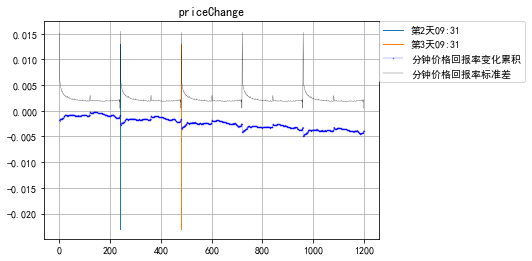

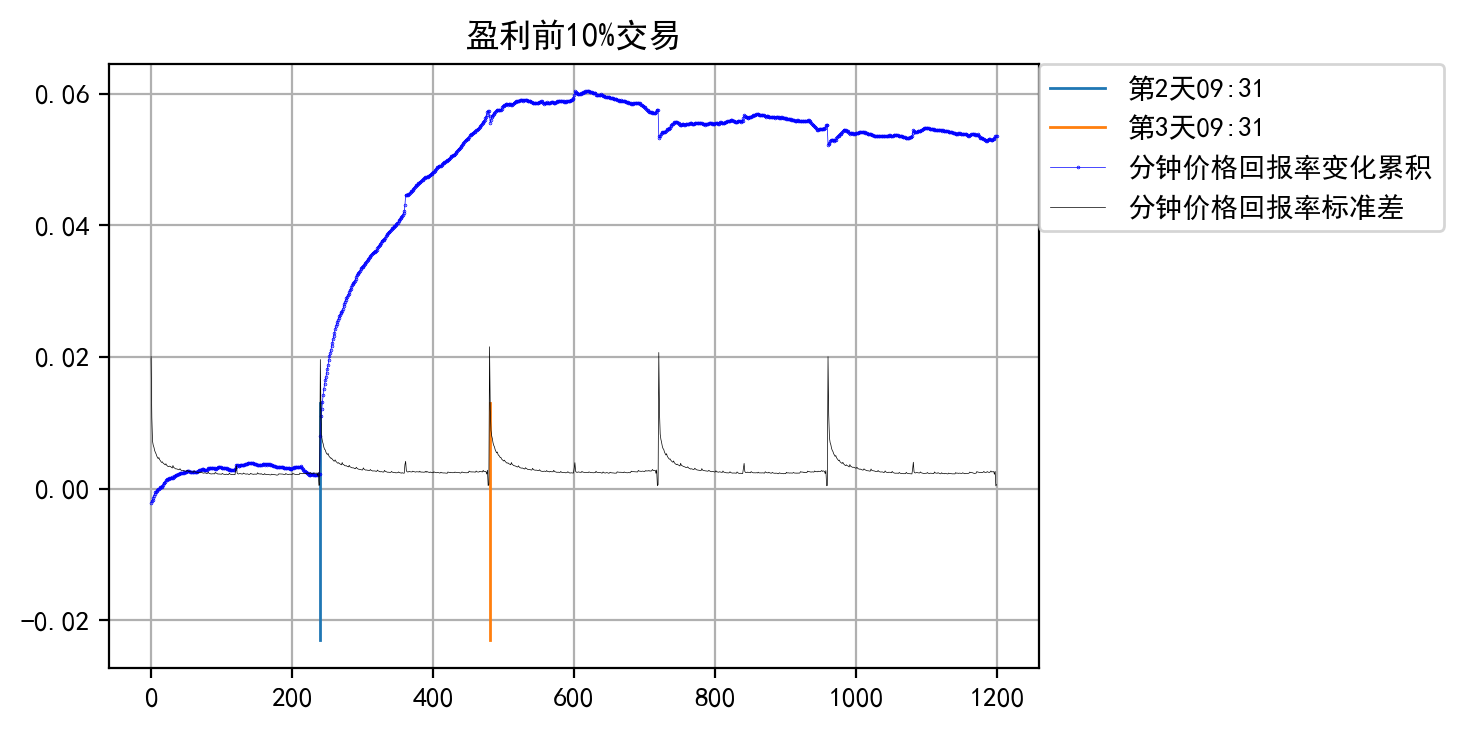

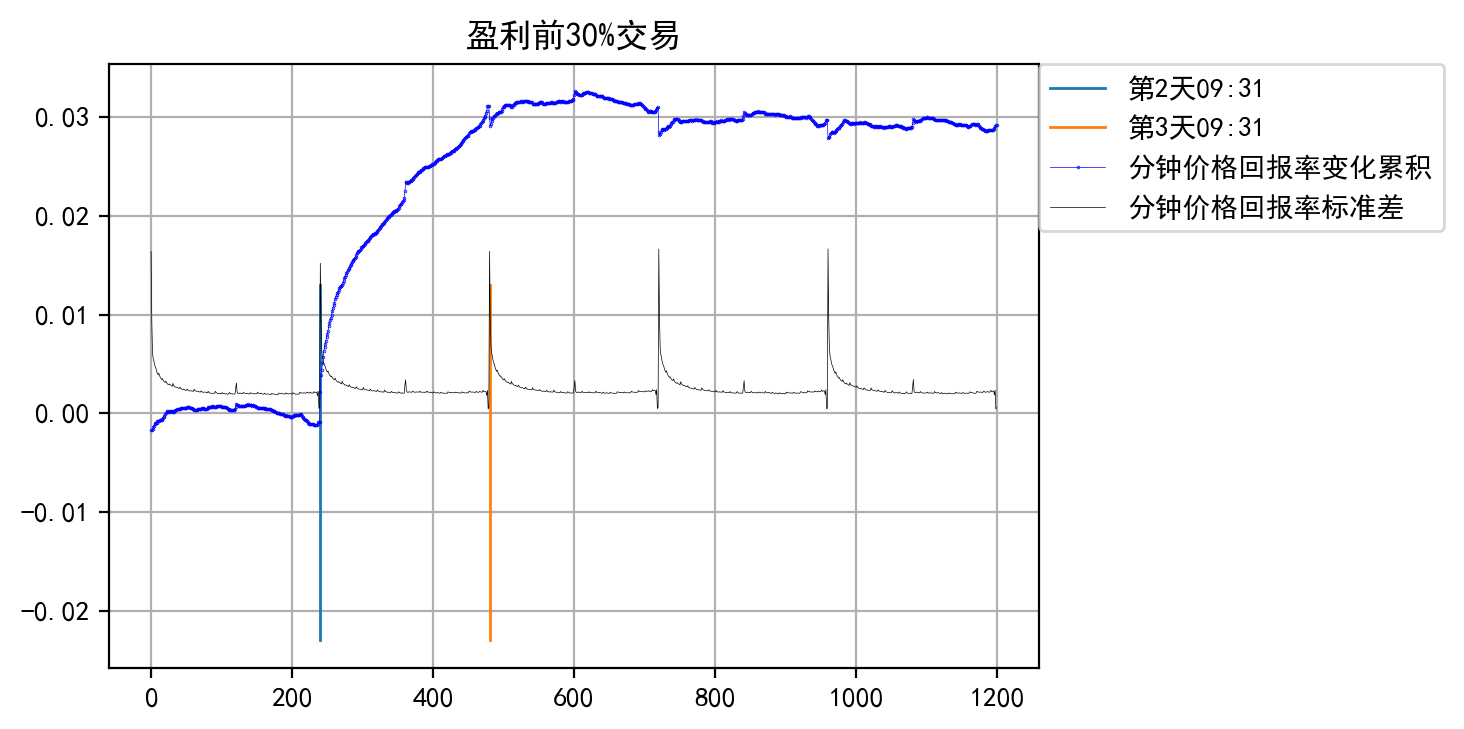

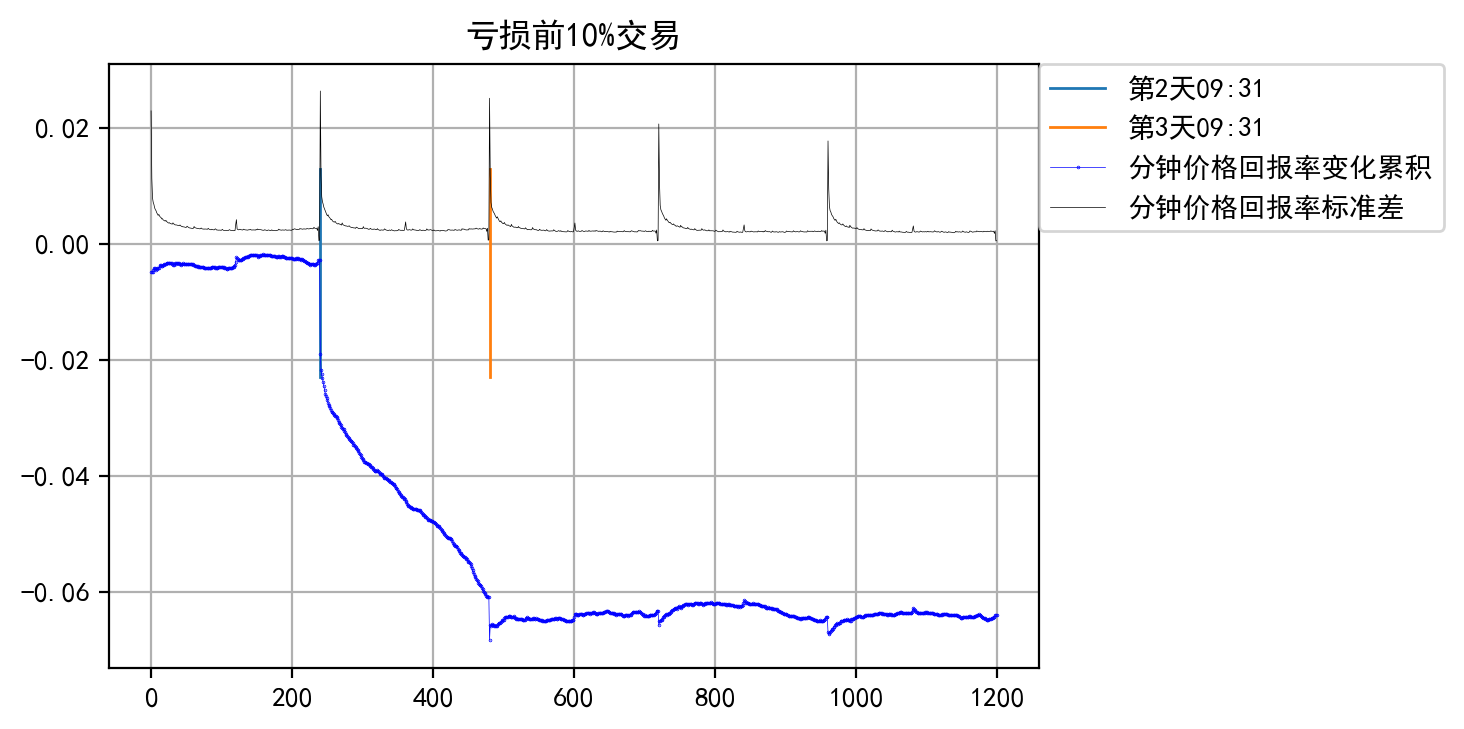

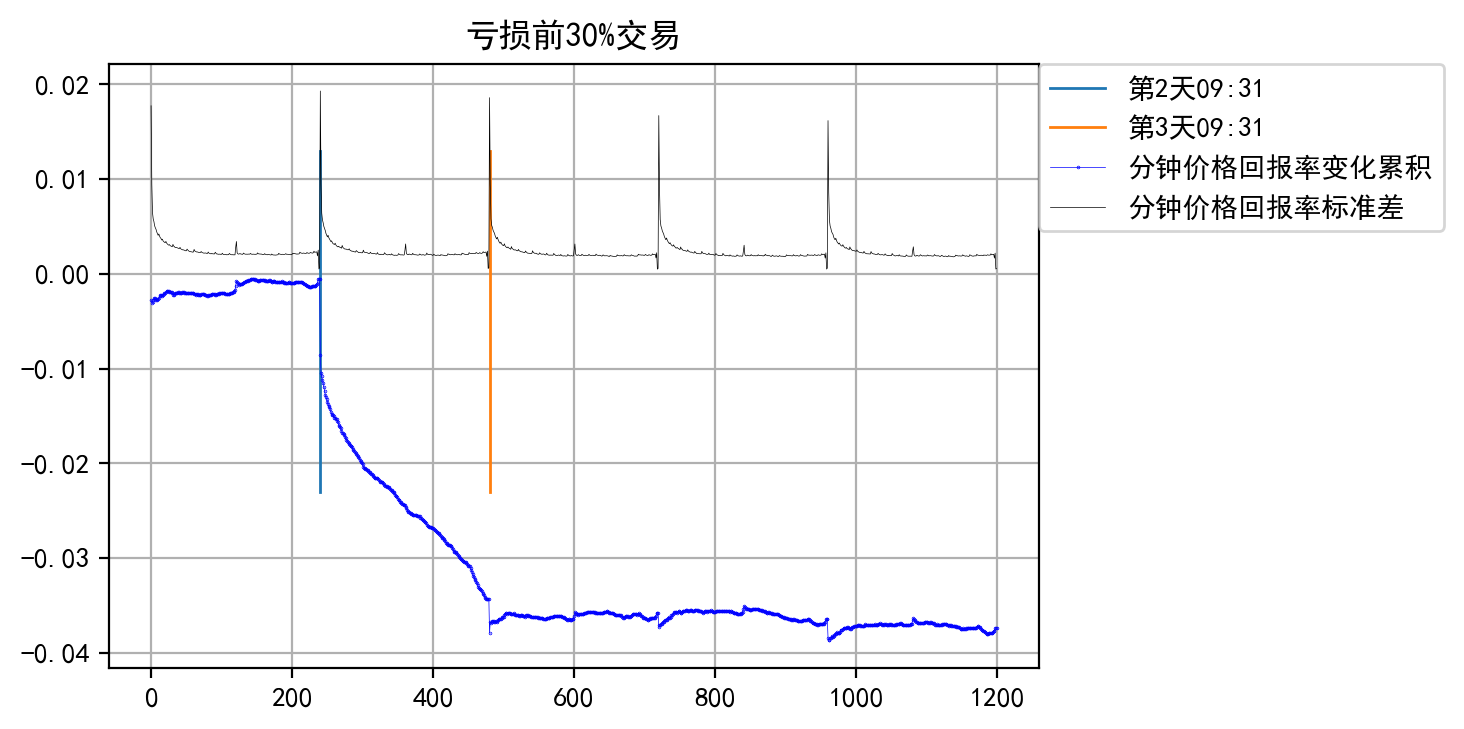

In [20]:
timeAsFloat, timeLabels, maxM, dayOff, dayTimeAsFloat = rschLib.getTimeLabels(maxD)
R = open_mtx[:, 1:]/close_mtx[:,:-1]-1  #使用收盘到开盘的回报率来修正分红和拆股
R = np.hstack((np.zeros((R.shape[0],1)), R))
tradesUsed, r_withnan = rschLib.getTradesFast(strategy_name, name, tkrs, dtes, maxD, dayTimeAsFloat, R)
# get trade samples by good/bad trades
tradeArea=[inTime,otTime]
idxTradable = np.isfinite(r_withnan[:,tradeArea[0]])
r = r_withnan.copy()
r[np.isfinite(r)==False]=0
result = rschLib.getTradeAnalysisSampleGroups(r, idxTradable, tradeArea)

# draw price change
rschLib.drawPriceChange(r[idxTradable,:], strategy_name, timeLabels=timeLabels, tp=tradeArea)
rschLib.drawPriceChange(result['rGood10'], strategy_name, timeLabels=timeLabels, title='盈利前10%交易', tp=tradeArea)
#rschLib.drawPriceChange(result['rGood20'], strategy_name, timeLabels=timeLabels, title='盈利前20%交易', tp=tradeArea)
rschLib.drawPriceChange(result['rGood30'], strategy_name, timeLabels=timeLabels, title='盈利前30%交易', tp=tradeArea)
rschLib.drawPriceChange(result['rBad10'], strategy_name, timeLabels=timeLabels, title='亏损前10%交易',  tp=tradeArea)
#rschLib.drawPriceChange(result['rBad20'], strategy_name, timeLabels=timeLabels, title='亏损前20%交易',  tp=tradeArea)
rschLib.drawPriceChange(result['rBad30'], strategy_name, timeLabels=timeLabels, title='亏损前30%交易',  tp=tradeArea)

# analyze tags
#rschLib.analyzeTradeTags(tradesUsed, result['rGood10'], result['idxGood10'], '盈利前10%交易',strategy_name, dtes, tkrs, offStart)
#rschLib.analyzeTradeTags(tradesUsed, result['rGood20'], result['idxGood20'], '盈利前20%交易',strategy_name, dtes, tkrs, offStart)
#rschLib.analyzeTradeTags(tradesUsed, result['rGood30'], result['idxGood30'], '盈利前30%交易',strategy_name, dtes, tkrs, offStart)
#rschLib.analyzeTradeTags(tradesUsed, result['rBad10'], result['idxBad10'], '亏损前10%交易',strategy_name, dtes, tkrs, offStart)
#rschLib.analyzeTradeTags(tradesUsed, result['rBad20'], result['idxBad20'], '亏损前20%交易',strategy_name, dtes, tkrs, offStart)
#rschLib.analyzeTradeTags(tradesUsed, result['rBad30'], result['idxBad30'], '亏损前30%交易',strategy_name, dtes, tkrs, offStart)

#get tag names
tnames, tagNamesEn,t2 = rschLib.getTagNames()
idxOverLapTagList=rschLib.analyzeTradeTags(tradesUsed, r, list(range(len(tradesUsed))), '所有交易',strategy_name, dtes, tkrs, offStart, "d:\\pklWeeklyUpdate\\")

#draw pnl and tag pnl
importlib.reload(rschLib)
[dtesByTrade, pnlByTrade] = rschLib.getPnlFast(r, dtes, tkrs, name, tradesUsed, inTime, otTime, dayOff, timeAsFloat, toDatabase='yes', strategy_name=strategy_name)
[dtesPnlAggr,pnlAggr, numTrades] = rschLib.aggregatePnlAndDtes(dtesByTrade, pnlByTrade)
rschLib.drawPNL(dtesPnlAggr, pnlAggr, dtes, strategy_name,showFigure='no', toDatabase='yes')
for i in range(len(tnames)):
    tagName = tnames[i]
    [dtesWithTag, pnlWithTag,n] = rschLib.aggregatePnlAndDtes(dtesByTrade[idxOverLapTagList[i]],pnlByTrade[idxOverLapTagList[i]])
    rschLib.drawPNL(dtesWithTag, pnlWithTag, dtes, strategy_name, showFigure='no', toDatabase='yes', dateStart=dtesPnlAggr[0], pnlType=tagName)
    rschLib.drawPNL(dtesWithTag, pnlWithTag, dtes, strategy_name+'+'+tagNamesEn[i], showFigure='no',  toDatabase='yes', dateStart=dtesPnlAggr[0], pnlType='pnl')

#analysis of number of trades vs performance
importlib.reload(rschLib)
rschLib.pnlVsNumtrades(pnlAggr, numTrades, strategy_name, toDatabase='yes')
rschLib.saveOffStart(strategy_name, offStart)